In [ ]:
! pip install -q imagecodecs
! pip install -q warmup_scheduler
! pip install -q efficientnet_pytorch
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download mvadlmi
! unzip mvadlmi.zip

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Create tiles
from create_tiles import add_column_tiles

# Deep learning model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
df_train = pd.read_csv("train.csv").drop([31, 57, 84, 137, 162, 245, \
                                          246, 267, 284, 316], axis=0).reset_index(drop=True) # These images are too big and crash the colab kernel
image_folder = "./train/train"
add_column_tiles(df_train, image_folder)

100%|██████████| 330/330 [4:04:43<00:00, 44.49s/it]


In [3]:
enet_type = "efficientnet-b0"
fold = 0
tile_size = 100
image_size = 100
n_tiles = 100
batch_size = 6
out_dim = 5
init_lr = 3e-4
warmup_factor = 10
n_epochs = 30
warmup_epo = 1
device = torch.device("cuda")

In [4]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i

In [5]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_pretrained(backbone)

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [6]:
class PANDADataset(Dataset):
    def __init__(self, df, image_size, n_tiles=n_tiles, rand=False, transform=None,):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        tiles = row.tiles
        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img
        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)

In [7]:
transforms_train = albumentations.Compose([albumentations.HorizontalFlip(p=0.5),
                                           albumentations.VerticalFlip(p=0.5),
                                           albumentations.Transpose(p=0.5)])

transforms_val = albumentations.Compose([])

In [8]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)

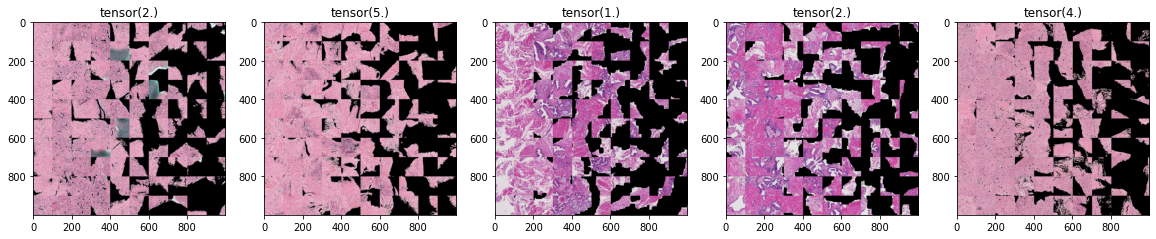

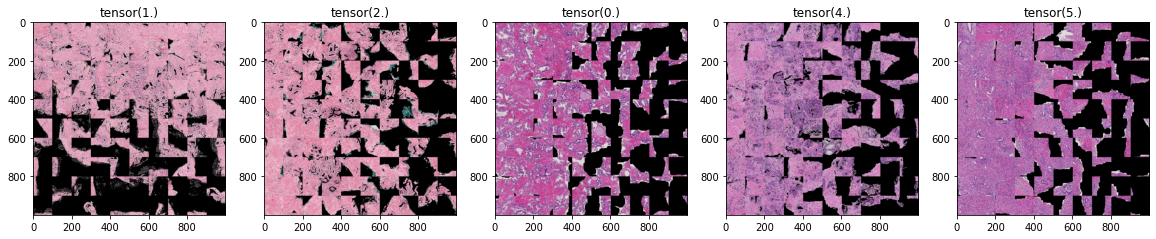

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))

In [10]:
criterion = nn.BCEWithLogitsLoss()

In [11]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss

In [13]:
def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    auc = roc_auc_score(pd.get_dummies(TARGETS), pd.get_dummies(PREDS))
    auc_k = roc_auc_score(pd.get_dummies(df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values), 
                          pd.get_dummies(PREDS[df_valid['data_provider'] == 'karolinska']))
    auc_r = roc_auc_score(pd.get_dummies(df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values), 
                          pd.get_dummies(PREDS[df_valid['data_provider'] == 'radboud']))
    
    print('auc', auc, 'auc_k', auc_k, 'auc_r', auc_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, auc


In [14]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=4)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=4)

model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0
264 66


In [15]:
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step()

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, auc = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, AUC: {(auc):.5f}'
    print(content)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Mon Mar 21 23:12:14 2022 Epoch: 1


100%|██████████| 11/11 [00:05<00:00,  2.14it/s]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


auc 0.6197138848477244 auc_k 0.6589280175469692 auc_r 0.6490166028097063
Mon Mar 21 23:12:47 2022 Epoch 1, lr: 0.0003000, train loss: 0.55082, val loss: 0.62822, acc: 13.63636, AUC: 0.61971
Mon Mar 21 23:12:47 2022 Epoch: 2


100%|██████████| 11/11 [00:04<00:00,  2.33it/s]


auc 0.5889218108816527 auc_k 0.5138878426680846 auc_r 0.524304567293073
Mon Mar 21 23:13:18 2022 Epoch 2, lr: 0.0003000, train loss: 0.45401, val loss: 0.58120, acc: 18.18182, AUC: 0.58892
Mon Mar 21 23:13:18 2022 Epoch: 3


100%|██████████| 11/11 [00:04<00:00,  2.37it/s]


auc 0.5812191010436288 auc_k 0.5846780655500413 auc_r 0.6171985390088839
Mon Mar 21 23:13:49 2022 Epoch 3, lr: 0.0002991, train loss: 0.42478, val loss: 0.55948, acc: 25.75758, AUC: 0.58122
Mon Mar 21 23:13:49 2022 Epoch: 4


100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


auc 0.6127554311285354 auc_k 0.6292328370554177 auc_r 0.63883776823432
Mon Mar 21 23:14:20 2022 Epoch 4, lr: 0.0002965, train loss: 0.36174, val loss: 0.51943, acc: 33.33333, AUC: 0.61276
Mon Mar 21 23:14:20 2022 Epoch: 5


100%|██████████| 11/11 [00:04<00:00,  2.43it/s]


auc 0.5775532983614285 auc_k 0.5800610623695301 auc_r 0.5817758316608891
Mon Mar 21 23:14:50 2022 Epoch 5, lr: 0.0002921, train loss: 0.36877, val loss: 0.55102, acc: 28.78788, AUC: 0.57755
Mon Mar 21 23:14:50 2022 Epoch: 6


100%|██████████| 11/11 [00:04<00:00,  2.46it/s]


auc 0.575398684270944 auc_k 0.5920924169916105 auc_r 0.5956955145748248
Mon Mar 21 23:15:21 2022 Epoch 6, lr: 0.0002861, train loss: 0.35745, val loss: 0.54898, acc: 31.81818, AUC: 0.57540
Mon Mar 21 23:15:21 2022 Epoch: 7


100%|██████████| 11/11 [00:04<00:00,  2.49it/s]


auc 0.6095645503947202 auc_k 0.5640223743550357 auc_r 0.5176836764767799
Mon Mar 21 23:15:51 2022 Epoch 7, lr: 0.0002785, train loss: 0.36129, val loss: 0.52251, acc: 36.36364, AUC: 0.60956
Mon Mar 21 23:15:51 2022 Epoch: 8


100%|██████████| 11/11 [00:04<00:00,  2.58it/s]


auc 0.6061583786261949 auc_k 0.5805629406435858 auc_r 0.5962198223232706
Mon Mar 21 23:16:21 2022 Epoch 8, lr: 0.0002694, train loss: 0.30593, val loss: 0.56612, acc: 34.84848, AUC: 0.60616
Mon Mar 21 23:16:21 2022 Epoch: 9


100%|██████████| 11/11 [00:04<00:00,  2.51it/s]


auc 0.595689652481484 auc_k 0.6222240069518296 auc_r 0.6185225604535949
Mon Mar 21 23:16:51 2022 Epoch 9, lr: 0.0002589, train loss: 0.29553, val loss: 0.49914, acc: 34.84848, AUC: 0.59569
Mon Mar 21 23:16:51 2022 Epoch: 10


100%|██████████| 11/11 [00:04<00:00,  2.55it/s]


auc 0.628380764398479 auc_k 0.6243721444326283 auc_r 0.6394987462516197
Mon Mar 21 23:17:21 2022 Epoch 10, lr: 0.0002471, train loss: 0.30142, val loss: 0.48497, acc: 39.39394, AUC: 0.62838
Mon Mar 21 23:17:21 2022 Epoch: 11


100%|██████████| 11/11 [00:04<00:00,  2.54it/s]


auc 0.6018014759034199 auc_k 0.5765050809405649 auc_r 0.64176593734065
Mon Mar 21 23:17:51 2022 Epoch 11, lr: 0.0002342, train loss: 0.24399, val loss: 0.52681, acc: 37.87879, AUC: 0.60180
Mon Mar 21 23:17:51 2022 Epoch: 12


100%|██████████| 11/11 [00:04<00:00,  2.55it/s]


auc 0.6066369147229609 auc_k 0.5901508773484581 auc_r 0.6304276428127004
Mon Mar 21 23:18:21 2022 Epoch 12, lr: 0.0002203, train loss: 0.23173, val loss: 0.42692, acc: 37.87879, AUC: 0.60664
Mon Mar 21 23:18:21 2022 Epoch: 13


100%|██████████| 11/11 [00:04<00:00,  2.58it/s]


auc 0.5620459235257602 auc_k 0.5487673057229508 auc_r 0.5481956081381368
Mon Mar 21 23:18:52 2022 Epoch 13, lr: 0.0002055, train loss: 0.23016, val loss: 0.52711, acc: 30.30303, AUC: 0.56205
Mon Mar 21 23:18:52 2022 Epoch: 14


100%|██████████| 11/11 [00:04<00:00,  2.64it/s]


auc 0.5725195660795309 auc_k 0.5207833609043286 auc_r 0.6129803657389864
Mon Mar 21 23:19:22 2022 Epoch 14, lr: 0.0001901, train loss: 0.22249, val loss: 0.47696, acc: 30.30303, AUC: 0.57252
Mon Mar 21 23:19:22 2022 Epoch: 15


100%|██████████| 11/11 [00:04<00:00,  2.65it/s]


auc 0.6172377567112646 auc_k 0.5733239542715349 auc_r 0.6456815291987705
Mon Mar 21 23:19:51 2022 Epoch 15, lr: 0.0001743, train loss: 0.20101, val loss: 0.59623, acc: 36.36364, AUC: 0.61724
Mon Mar 21 23:19:51 2022 Epoch: 16


100%|██████████| 11/11 [00:04<00:00,  2.57it/s]


auc 0.5877072142638537 auc_k 0.5711537846114458 auc_r 0.6270340617237168
Mon Mar 21 23:20:21 2022 Epoch 16, lr: 0.0001581, train loss: 0.21188, val loss: 0.60137, acc: 34.84848, AUC: 0.58771
Mon Mar 21 23:20:21 2022 Epoch: 17


100%|██████████| 11/11 [00:04<00:00,  2.60it/s]


auc 0.5752713605111811 auc_k 0.511648930146914 auc_r 0.5996562600872944
Mon Mar 21 23:20:51 2022 Epoch 17, lr: 0.0001419, train loss: 0.17788, val loss: 0.47999, acc: 30.30303, AUC: 0.57527
Mon Mar 21 23:20:51 2022 Epoch: 18


100%|██████████| 11/11 [00:04<00:00,  2.68it/s]


auc 0.5717354505075107 auc_k 0.5708102180077986 auc_r 0.5627803858550985
Mon Mar 21 23:21:21 2022 Epoch 18, lr: 0.0001257, train loss: 0.15188, val loss: 0.55420, acc: 31.81818, AUC: 0.57174
Mon Mar 21 23:21:21 2022 Epoch: 19


100%|██████████| 11/11 [00:04<00:00,  2.66it/s]


auc 0.6061517825085062 auc_k 0.6089925262909134 auc_r 0.6260688321895218
Mon Mar 21 23:21:51 2022 Epoch 19, lr: 0.0001099, train loss: 0.19840, val loss: 0.69699, acc: 39.39394, AUC: 0.60615
Mon Mar 21 23:21:51 2022 Epoch: 20


100%|██████████| 11/11 [00:04<00:00,  2.69it/s]


auc 0.6033106855434043 auc_k 0.5754290120721572 auc_r 0.6228285475699269
Mon Mar 21 23:22:21 2022 Epoch 20, lr: 0.0000945, train loss: 0.16146, val loss: 0.58517, acc: 36.36364, AUC: 0.60331
Mon Mar 21 23:22:21 2022 Epoch: 21


100%|██████████| 11/11 [00:04<00:00,  2.60it/s]


auc 0.5984740677504233 auc_k 0.593181865177833 auc_r 0.6225911306658434
Mon Mar 21 23:22:50 2022 Epoch 21, lr: 0.0000797, train loss: 0.16453, val loss: 0.49295, acc: 33.33333, AUC: 0.59847
Mon Mar 21 23:22:50 2022 Epoch: 22


100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


auc 0.5860082312948488 auc_k 0.6393428748670684 auc_r 0.602709839117885
Mon Mar 21 23:23:20 2022 Epoch 22, lr: 0.0000658, train loss: 0.14287, val loss: 0.52894, acc: 34.84848, AUC: 0.58601
Mon Mar 21 23:23:20 2022 Epoch: 23


100%|██████████| 11/11 [00:04<00:00,  2.69it/s]


auc 0.5849769400857981 auc_k 0.6203179465024222 auc_r 0.5717609901805304
Mon Mar 21 23:23:50 2022 Epoch 23, lr: 0.0000529, train loss: 0.11886, val loss: 0.50225, acc: 33.33333, AUC: 0.58498
Mon Mar 21 23:23:50 2022 Epoch: 24


100%|██████████| 11/11 [00:04<00:00,  2.69it/s]


auc 0.5918011240028052 auc_k 0.5530743382961125 auc_r 0.6228361495890232
Mon Mar 21 23:24:19 2022 Epoch 24, lr: 0.0000411, train loss: 0.13882, val loss: 0.49287, acc: 33.33333, AUC: 0.59180
Mon Mar 21 23:24:19 2022 Epoch: 25


100%|██████████| 11/11 [00:04<00:00,  2.69it/s]


auc 0.5920326486930283 auc_k 0.6054942285537043 auc_r 0.623448147212515
Mon Mar 21 23:24:49 2022 Epoch 25, lr: 0.0000306, train loss: 0.12875, val loss: 0.50679, acc: 36.36364, AUC: 0.59203
Mon Mar 21 23:24:49 2022 Epoch: 26


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


auc 0.579088688907775 auc_k 0.6061122681082358 auc_r 0.5775927680238024
Mon Mar 21 23:25:18 2022 Epoch 26, lr: 0.0000215, train loss: 0.12570, val loss: 0.51551, acc: 33.33333, AUC: 0.57909
Mon Mar 21 23:25:18 2022 Epoch: 27


100%|██████████| 11/11 [00:03<00:00,  2.78it/s]


auc 0.579088688907775 auc_k 0.6061122681082358 auc_r 0.5775927680238024
Mon Mar 21 23:25:48 2022 Epoch 27, lr: 0.0000139, train loss: 0.11729, val loss: 0.51232, acc: 33.33333, AUC: 0.57909
Mon Mar 21 23:25:48 2022 Epoch: 28


100%|██████████| 11/11 [00:04<00:00,  2.74it/s]


auc 0.5856842449247414 auc_k 0.6062382761727519 auc_r 0.6084569655546667
Mon Mar 21 23:26:17 2022 Epoch 28, lr: 0.0000079, train loss: 0.10821, val loss: 0.51441, acc: 34.84848, AUC: 0.58568
Mon Mar 21 23:26:17 2022 Epoch: 29


100%|██████████| 11/11 [00:04<00:00,  2.70it/s]


auc 0.5972834559124678 auc_k 0.6062382761727519 auc_r 0.6326075510270912
Mon Mar 21 23:26:47 2022 Epoch 29, lr: 0.0000035, train loss: 0.13529, val loss: 0.52022, acc: 36.36364, AUC: 0.59728
Mon Mar 21 23:26:47 2022 Epoch: 30


100%|██████████| 11/11 [00:04<00:00,  2.64it/s]

auc 0.5972834559124678 auc_k 0.6062382761727519 auc_r 0.6326075510270912
Mon Mar 21 23:27:17 2022 Epoch 30, lr: 0.0000009, train loss: 0.10828, val loss: 0.52225, acc: 36.36364, AUC: 0.59728
